# PRA3024 Assignment 2 - Gravitational wave data analysis.
Nick Milkin

# **Problem 1 - Matched Filter**

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 92.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
    

In [2]:
from __future__ import division

import numpy
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform

# Part 1
Downloading, preparing and resampling data

In [3]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

--2023-03-15 21:06:14--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  42.0MB/s    in 1.3s    

2023-03-15 21:06:16 (42.0 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2023-03-15 21:06:16--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  43.0MB/s    in 1.4s    

20

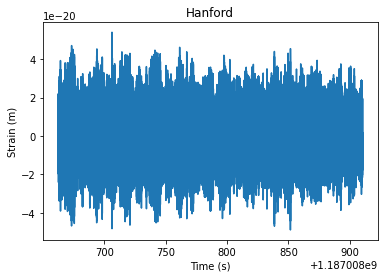

In [4]:
%matplotlib inline
import pylab
from pycbc.filter import highpass, resample_to_delta_t
from pycbc.catalog import Merger
from pycbc.frame import read_frame

merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
  # We'll download the data and select 256 seconds that includes the event time
  ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                  "{}:LOSC-STRAIN".format(ifo),
                  start_time=merger.time - 224,
                  end_time=merger.time + 32,
                  check_integrity=False)
  
  # Read the detector data and remove low frequency content
  # Also resampling it to 2048 Hz
  strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)

  # Remove time corrupted by the high pass filter 
  strain[ifo] = strain[ifo].crop(4, 4)

  # Also create a frequency domain version of the data
  stilde[ifo] = strain[ifo].to_frequencyseries()

pylab.plot(strain['H1'].sample_times, strain['H1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain (m)')
pylab.title('Hanford')
pylab.show()

# Part 2
Matched filter between the given data and a
template waveform

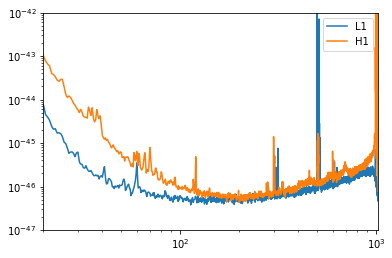

In [5]:
# Power spectral density

import pycbc.psd
from pycbc.psd import interpolate, welch

psds = {}
for ifo in ['L1', 'H1']:
    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

In [6]:
# Signal to Noise Ratio

from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q

mass1 = numpy.arange(1.1, 3, 0.1) # mass range bewteen 1 to 3 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=20.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0)
    
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=20.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0)
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

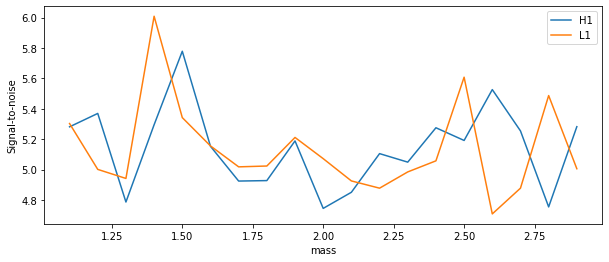

In [7]:
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

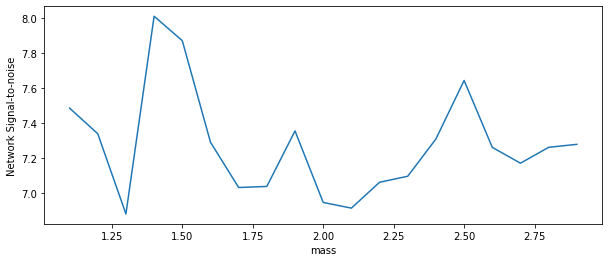

We found the best Mass1=Mass2 was 1.40 solar masses (detector frame)


In [8]:
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

We found mass for the best SNR to be equal to 1.4

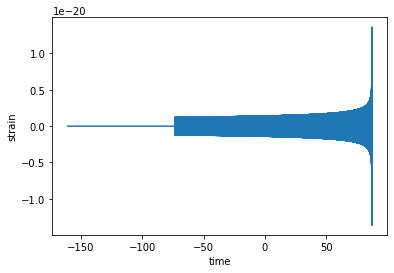

In [9]:
m = 1.4 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))

template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

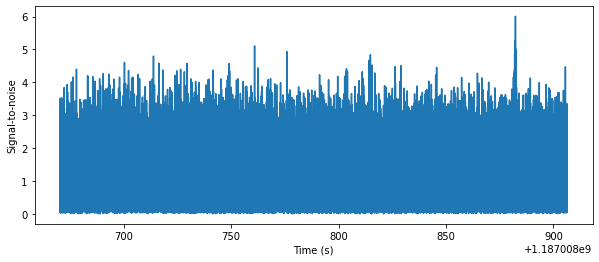

We found a signal at 1187008882.3091798s with SNR 6.008504166136228


In [10]:
ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

We see that there is a signal, however, SNR of 6 is not very high, meaning that the data is very heavy in noise

Time of the peak: 1187008882 +1.187008e9 s

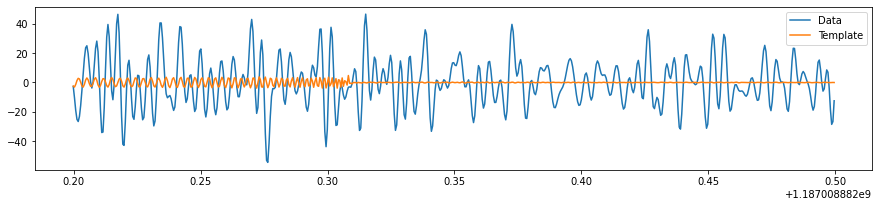

In [11]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

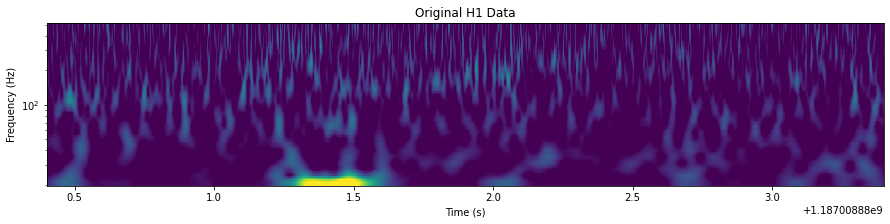

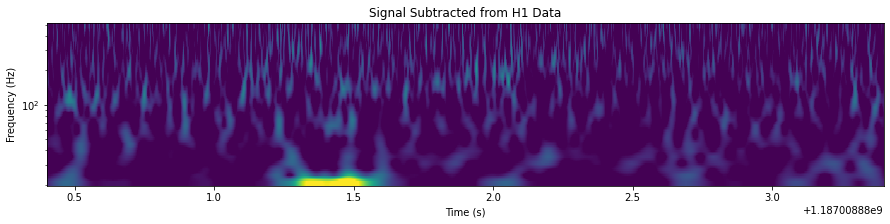

In [12]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

# Part 3
Investigate the correlation in the parameter space of gravitational waves from compact binary coalescences

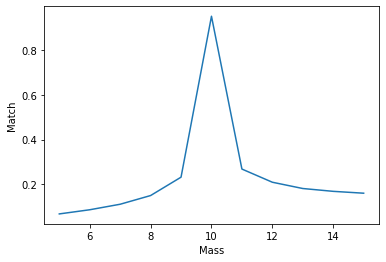

In [13]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 30
sample_rate = 4096
mass_lst = numpy.arange(5, 16, 1)
match_lst = [];

# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant='EOBNRv2',
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

for mass in mass_lst:
  sp, sc = get_td_waveform(approximant='TaylorT4',
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen // 2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # Note: This takes a while the first time as an FFT plan is generated
  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)

  match_lst.append(m)

pylab.plot(mass_lst, numpy.array(match_lst))
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.show()

Maximum match is produced at mass=10, as expected

# **Problem 2 - Detector Noise**

# Part 1
Loading the data and getting PSD

In [14]:
#Mounting drive on colab
#if not working on colab, ignore this part
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import numpy as np

d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') 

In [39]:
from pycbc import types

dt = d[:, 0]
data = types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries

Data loaded, time to calculate the SNR


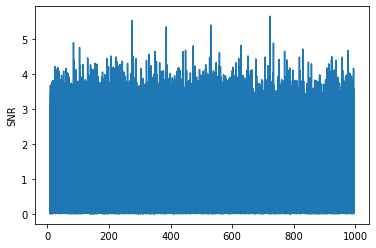

Max SNR: 5.655888304894803


In [65]:
mass1 = numpy.arange(5, 10, 0.5) # mass range bewteen 5 to 10 Solar mass
mass2 = mass1

psd = interpolate(welch(data), 1.0 / data.duration)
strain=data.to_frequencyseries()

Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                                            mass1=m,
                                            mass2=m,
                                            delta_f=strain.delta_f,
                                            f_lower=20.0)

    # We will resize the vector to match our data

    hp.resize(len(strain))
    
    snr = matched_filter(hp, strain,
                         psd=psd, low_frequency_cutoff=20.0)
    
    snr = snr.crop(4 + 4, 4)

    Snr_list.append(max(abs(snr)))

pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('SNR')
pylab.show()
print('Max SNR:', max(abs(snr))) 

Maximum SNR found to be 5.66 - lower that 8, therefore no real signal is present, only noise.

# Part 2
Whitening the data

In [41]:
from scipy.stats import norm

In [50]:
# We do it this way so that we can whiten both the template and the data

import pycbc.psd
white_data = (data.to_frequencyseries() / psd ** 0.5).to_timeseries()
white_data = white_data.crop(4 + 4, 4)

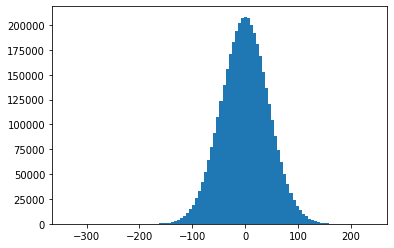

In [51]:
plt.hist(white_data, bins=100)
plt.show()

(array([4.28490233e-08, 0.00000000e+00, 0.00000000e+00, 4.28490233e-08,
        4.28490233e-08, 0.00000000e+00, 4.28490233e-08, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.28490233e-08,
        4.28490233e-08, 0.00000000e+00, 0.00000000e+00, 4.28490233e-08,
        4.28490233e-08, 0.00000000e+00, 1.71396093e-07, 0.00000000e+00,
        0.00000000e+00, 2.99943163e-07, 1.71396093e-07, 4.71339256e-07,
        4.28490233e-07, 1.37116875e-06, 2.18530019e-06, 2.74233749e-06,
        6.21310838e-06, 1.01980675e-05, 1.43115738e-05, 2.21957941e-05,
        3.53504442e-05, 5.13759790e-05, 7.61855635e-05, 1.14449741e-04,
        1.67968171e-04, 2.38326268e-04, 3.39621359e-04, 4.67997033e-04,
        6.24824458e-04, 8.25914924e-04, 1.09243585e-03, 1.41016136e-03,
        1.78329065e-03, 2.23273406e-03, 2.75467801e-03, 3.31848546e-03,
        3.92115697e-03, 4.60185656e-03, 5.28756948e-03, 5.98952218e-03,
        6.67086450e-03, 7.33780954e-03, 7.84929834e-03, 8.328778

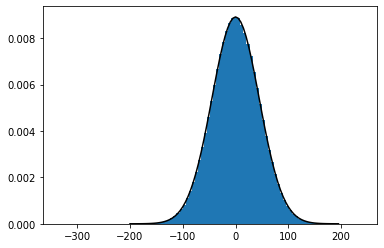

In [52]:
(mu, sigma) = norm.fit(white_data)
gauss=norm.pdf(range(-200, 200, 5), mu, sigma)
pylab.plot(range(-200, 200, 5), gauss, 'k')
pylab.hist(white_data, bins=100, density=True)

We have shown that whitened data follows Gaussian distribution with zero mean

# Part 3
Stationarity of noise

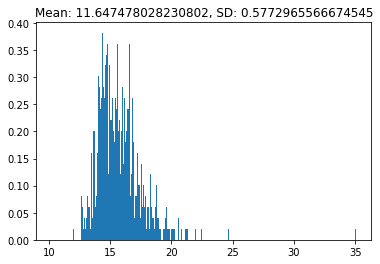

In [63]:
from pycbc.filter import sigmasq
from pycbc.waveform import get_fd_waveform
from statistics import mean, stdev

hp, hc = get_fd_waveform(approximant="TaylorF2", 
                         mass1=3, 
                         mass2=3, 
                         delta_f=1.0/(200.0) , 
                         distance = 500,  
                         f_lower=20.0, f_final = 2048.0)    #Luminosity distance = 500 Mpc 


# we now divide data into chunks
n_chunks = 500
chunks = int(len(data) / n_chunks)
SNR = []

for i in range(n_chunks):

  data_chunk = data[i * chunks: (i + 1) * chunks]

  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk), hp.delta_f)

  snr = (pycbc.filter.sigmasq(hp, psds)) ** 0.5 # from hints

  SNR.append(snr)


# make a histogram out of the estimated SNR

plt.hist(SNRlist, bins = n_chunks, density=True)

plt.title(f'Mean: {mean(SNR)}, SD: {stdev(SNR)}')

plt.show()

The distribution is clearly not Gaussian, so we proved the non-stationarity of noise